A equação (1) é conhecida como Vetores autoregressivos aumentado por Fatores, FAVAR

$$
\begin{bmatrix}
F_t \\
Y_t 
\end{bmatrix}
= \Phi(L)
\begin{bmatrix}
F_{t-1} \\
Y_{t-1}
\end{bmatrix}
+ V_t
$$

Onde: 
$F_t$ é um vetor de fatores não observados, 
$Y_t$ é um vetor de variáveis observadas, 
$\Phi(L)$ é uma matriz de polinômios de defasagem,
$V_t$ é um vetor de resíduos. 

O vetor $Y_t$ contém $M$ variáveis econômicas observáveis.
O vetor $F_t$ contém $K$ fatores não observados que supostamente influenciam as variáveis econômicas;

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.api import VAR

warnings.filterwarnings("ignore")

pd.set_option('display.float_format', lambda x: '%.8f' % x)

In [2]:
df = pd.read_excel("bbedata.xlsx",index_col=0, parse_dates=True)
df.index = df.index.strftime('%m/%Y')

In [3]:
scaler = StandardScaler()
scaler.fit(df)
scaled_data = scaler.transform(df)

In [4]:
slow_variables = df[["IP", "LHUR", "PUNEW", "IPP", "IPF", "IPC", "IPCD", "IPCN", "IPE", "IPI", "IPM",
                  "IPMD", "IPMND", "IPMFG", "IPD", "IPN", "IPMIN", "IPUT", "IPXMCA", "PMI", "PMP",
                  "GMPYQ", "GMYXPQ", "LHEL", "LHELX", "LHEM", "LHNAG", "LHU680", "LHU5", "LHU14",
                  "LHU15", "LHU26", "LPNAG", "LP", "LPGD", "LPMI", "LPCC", "LPEM", "LPED", "LPEN",
                  "LPSP", "LPTU", "LPT", "LPFR", "LPS", "LPGOV", "LPHRM", "LPMOSA", "PMEMP", "GMCQ",
                  "GMCDQ", "GMCNQ", "GMCSQ", "GMCANQ", "PWFSA", "PWFCSA", "PWIMSA", "PWCMSA", "PSM99Q",
                  "PU83", "PU84", "PU85", "PUC", "PUCD", "PUS", "PUXF", "PUXHS", "PUXM", "LEHCC", "LEHM"]]

Calcula a média e o desvio padrão de cada variável e normaliza os dados.

$$
Z = \frac{(X - U)}{S}
$$

Onde:
$Z$ é o valor normalizado,
$X$ é o valor original,
$U$ é a média dos valores originais,
$S$ é o desvio padrão dos valores originais.


In [5]:
scaler.fit(slow_variables)
scaled_slow_data = scaler.transform(slow_variables)

In [6]:
#dataframe of scaled data
data_s = pd.DataFrame(scaled_data)
data_s.columns = df.columns
data_s.index = df.index

FYFF = data_s["FYFF"].reset_index(drop=True)

In [7]:
# PCA on entire dataset is C
pca = PCA(n_components=3)

C = pd.DataFrame(pca.fit_transform(scaled_data))

# rename columns to PC1, PC2, PC3
C.columns = ["PC1", "PC2", "PC3"]
C["PC3"] = C["PC3"] * - 1

In [8]:
F_slow = pd.DataFrame(pca.fit_transform(scaled_slow_data))
F_slow.columns = ["F1", "F2", "F3"]

F_slow["FYFF"] = FYFF

# merge C and df2
F_slow = pd.concat([C, F_slow], axis=1)

A Equação (1) não pode ser estimada diretamente uma vez que os fatores $\( F_t \)$ são inobserváveis e devem ser substituídos por $\( \hat{F}_t \)$.
Os fatores estimados, $\( \hat{F}_t \)$, são assumidos baseados em um número de séries temporais que coletivamente são denotadas pelo vetor $\( N \times 1 \) \( X_t \)$.
Qualquer economia desenvolvida envolve muitas atividades diferentes que podem ser descritas por várias séries temporais.
Assim, o número de séries temporais $\( N \)$ em $\( X_t \)$ é considerado grande, e pode ser bem maior que $\( T \)$, o número de períodos de tempo.
Bernanke et al. (2005) assumem que as séries temporais em $\( X_t \)$ estão relacionadas aos fatores inobserváveis $\( F_t \)$ e às variáveis econômicas observáveis $\( Y_t \)$ por uma equação dada por

$$
\[
    X_t = \Lambda F_t + \Lambda^Y Y_t + e_t
\]
$$
Onde $\( \Lambda \)$ é uma matriz $\( N \times K \)$ de fatores carregados,
$\( \Lambda^Y \)$ tem dimensão $\( N \times M \)$
$\( e_t \)$ é $\( N \times 1 \)$ um vetor de erros com média zero.

A equação (2) expressa a ideia de que tanto $\( Y_t \)$ como $\( F_t \)$, que podem ser correlacionados, expressão as relações contidas em $\( X_t \)$.

In [9]:
Factor = pd.DataFrame()

def perform_ols_and_update_factor(dependent_var):
    y = C[[dependent_var]]
    x = F_slow[["FYFF", "F1", "F2", "F3"]]
    x = sm.add_constant(x)
    model = sm.OLS(y, x).fit()
    F_hat = C - np.dot(data_s["FYFF"].values.reshape(-1, 1), model.params[1])
    Factor[dependent_var] = F_hat[dependent_var]

In [10]:
# Call the function for each dependent variable
perform_ols_and_update_factor("PC1")
perform_ols_and_update_factor("PC2")
perform_ols_and_update_factor("PC3")

Factor["FYFF"] = data_s["FYFF"].reset_index(drop=True)
df_var = Factor

In [11]:
F_hat = Factor[["PC1", "PC2", "PC3","FYFF"]].values
loadings = pd.DataFrame(np.linalg.lstsq(F_hat, data_s, rcond=None)[0])
loadings.columns = df.columns
loadings.index = ["PC1", "PC2", "PC3","FYFF"]

Inclusão dos Fatores no VAR: 
Uma vez estimados, esses fatores são incluídos como variáveis adicionais no modelo VAR, 
permitindo que o modelo capture as dinâmicas mais amplas da economia que não seriam capturadas apenas pelas variáveis observáveis.

A equação (1) do modelo FAVAR, agora com os fatores devidamente estimados pode ser expressa pela equação (3):

$$
\begin{bmatrix}
\( \hat{F}_t \)\\
Y_t 
\end{bmatrix}
= \Phi(L)
\begin{bmatrix}
\( \hat{F}_{t-1} \) \\
Y_{t-1}
\end{bmatrix}
+ V_t
$$

Onde: 
$\hat{F}_t$ é um vetor de fatores estimados pela equação (2), 
$Y_t$ é um vetor de variáveis observadas, 
$\Phi(L)$ é uma matriz de polinômios de defasagem,
$V_t$ é um vetor de resíduos. 

O vetor $Y_t$ contém $M$ variáveis econômicas observáveis.
O vetor $\hat{F}_t$ contém $K$ fatores estimados a partir das séries temporais que influenciam a economia;




In [12]:
# O modelo FAVAR estimado é dado por:

model = VAR(df_var)
results = model.fit(13, trend="c")
resid = results.resid
params = results.params
lag_order = results.k_ar


orth_irf = results.irf(48).orth_irfs
irf_fyff = orth_irf[:, :, results.names.index('FYFF')]
irf_fyff = pd.DataFrame(irf_fyff)
irf_fyff.index = range(0, 49)

# Calculando o desvio padrão do impulso e escalando o IRF
impulse_sd = 0.25 / df['FYFF'].std()
scale = impulse_sd / irf_fyff[3].iloc[0]

irf_line = np.dot(irf_fyff, loadings.iloc[:4]) * scale

In [13]:
# Processo de bootstrap para calcular os intervalos de confiança
R = 500  # Número de simulações bootstrap
nvars = 120  # Variáveis incluídas no modelo
nsteps = 49  # Período de tempo para a previsão

# Array para armazenar os IRFs
IRFs = np.zeros((nsteps, nvars, R))
Upper = np.zeros((nsteps, nvars))
Lower = np.zeros((nsteps, nvars))

# Simulando os resíduos do modelo
for j in range(R):
    # Resample residuals with replacement
    resampled_resid = resid.sample(n=len(resid), replace=True, random_state=j).reset_index(drop=True)  # Reset index

    # Creating the bootstrapped dataset
    data_boot = df_var.copy()
    for i in range(lag_order, len(df_var)):
        # Construct the array of lagged values
        lagged_values = []
        for lag in range(1, lag_order + 1):
            lagged_values.extend(data_boot.iloc[i - lag].values)

        if 'const' in results.model.exog_names:
            lagged_values.insert(0, 1)

        lagged_values = np.array(lagged_values)
        predicted_value = np.dot(lagged_values, results.params) + resampled_resid.iloc[i - lag_order].values
        data_boot.iloc[i] = predicted_value

    # Ajustando o modelo VAR no dataset com residuals  
    model_boot = VAR(data_boot)
    results_boot = model_boot.fit(13, trend='c')

    # Calculando os IRFs para cada variável no dataset com bootstrap
    irf_res = results_boot.irf(48).orth_irfs
    for i in range(nvars):
        irf_transformed = np.dot(irf_res[:, :, results_boot.names.index('FYFF')], loadings.iloc[:4, i]) * scale
        IRFs[:, i, j] = irf_transformed[:nsteps]

# Calculando os intervalos de confiança com os quartis de 95% e 5%
for k in range(nsteps):
    for i in range(nvars):
        Upper[k, i] = np.quantile(IRFs[k, i, :], 0.95)
        Lower[k, i] = np.quantile(IRFs[k, i, :], 0.05)

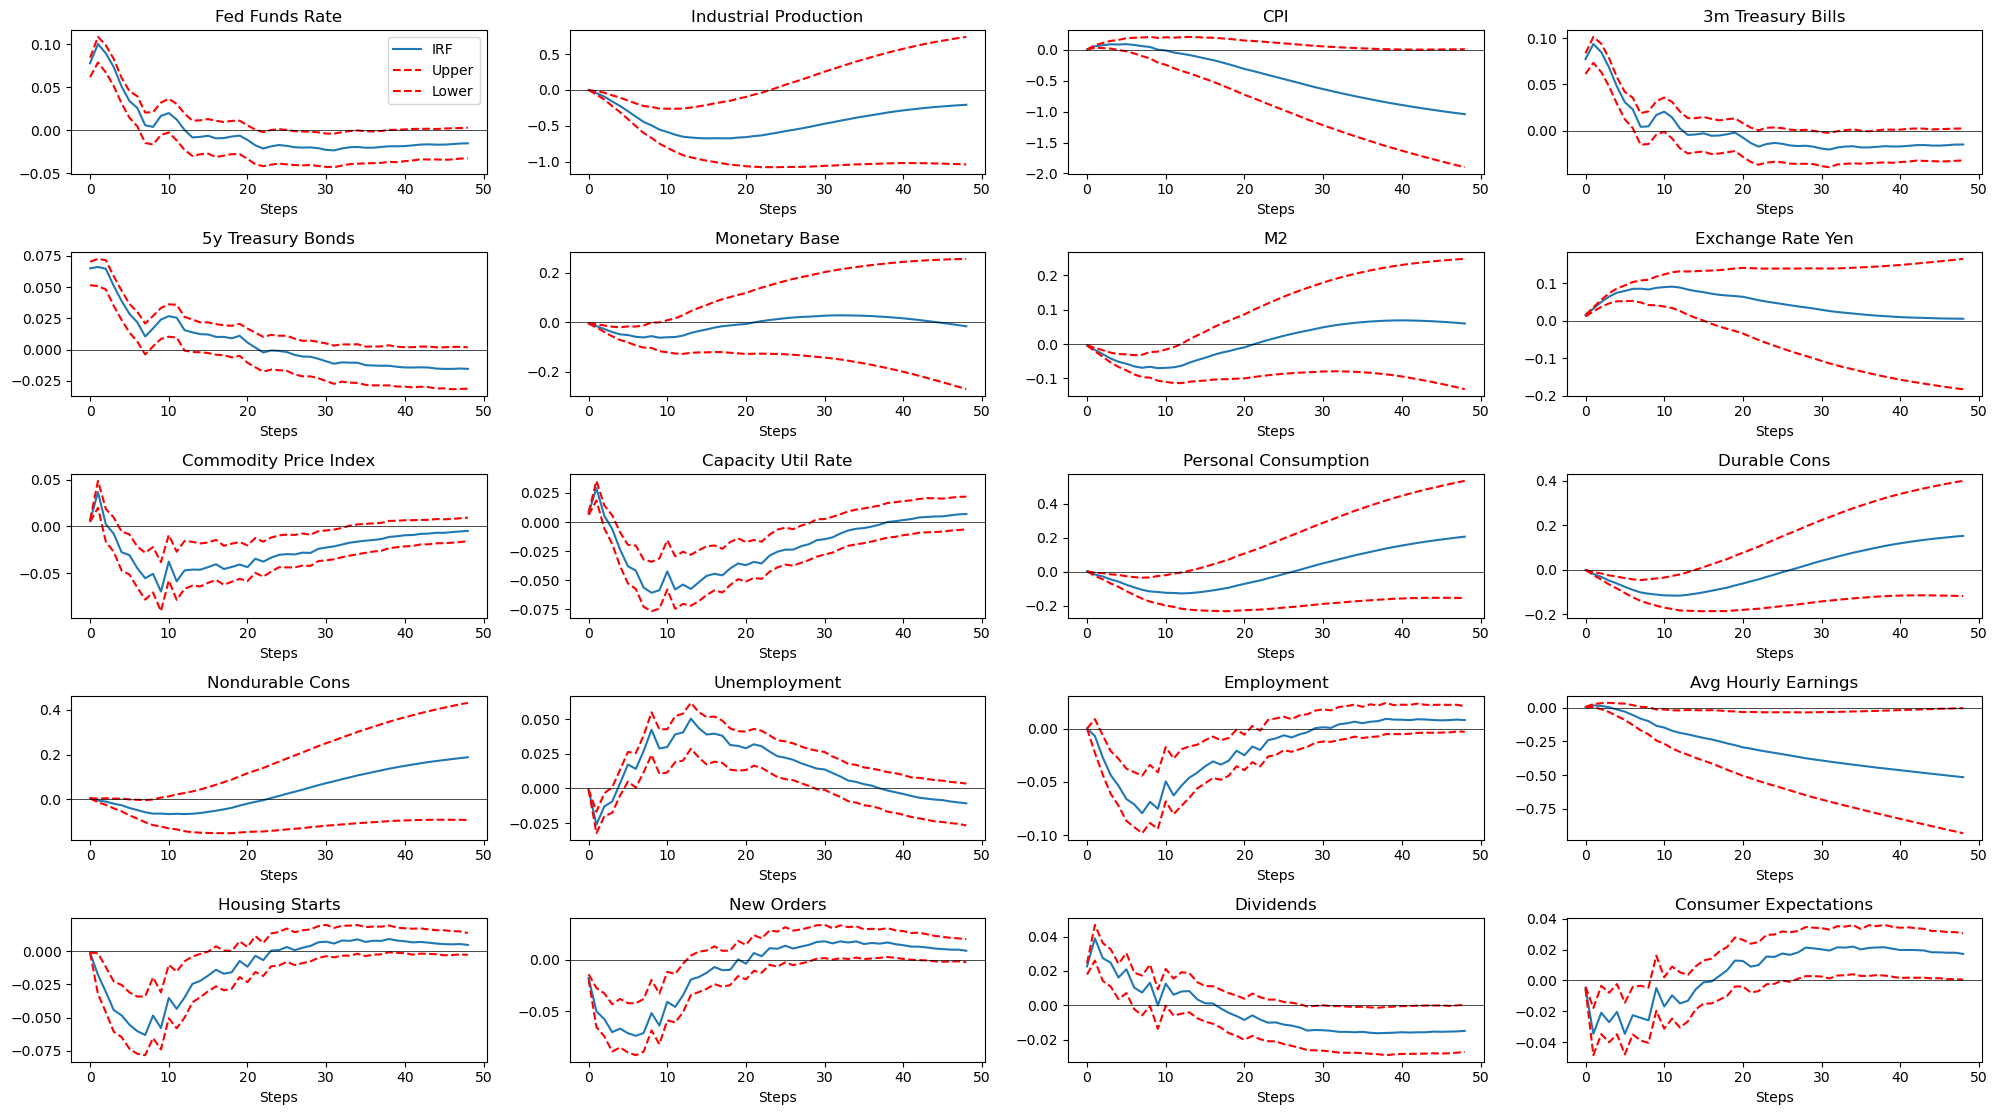

In [14]:
# Plotando os IRFs
variables = ["FYFF", "IP", "PUNEW", "FYGM3", "FYGT5", "FMFBA", 
             "FM2", "EXRJAN", "PMCP", "IPXMCA", "GMCQ", "GMCDQ", 
             "GMCNQ", "LHUR", "PMEMP", "LEHM", "HSFR", "PMNO", "FSDXP", "HHSNTN"]

transf_code = [1, 5, 5, 1, 1, 5, 5, 5, 1, 1, 5, 5, 5, 1, 1, 5, 1, 1, 1, 1]

variable_names = ["Fed Funds Rate", "Industrial Production", "CPI", "3m Treasury Bills",
                  "5y Treasury Bonds", "Monetary Base", "M2", "Exchange Rate Yen", 
                  "Commodity Price Index", "Capacity Util Rate", "Personal Consumption", 
                  "Durable Cons", "Nondurable Cons", "Unemployment", "Employment", 
                  "Avg Hourly Earnings", "Housing Starts", "New Orders", "Dividends", "Consumer Expectations"]

# Create a 5x4 grid of subplots and set the figure size in pixels
fig, axs = plt.subplots(5, 4, figsize=(1920 / 96, 1080 / 96))

fig.subplots_adjust(hspace=0.5, wspace=0.5)

# Iterate over each variable
for i, var in enumerate(variables):
    # Get the index of the variable in the dataframe
    index = data_s.columns.get_loc(var)

    # Get the subplot axes
    ax = axs[i // 4, i % 4]

    # Plot the IRF, cumulative sum if transf_code is 5
    if transf_code[i] == 5:
        ax.plot(irf_line[:, index].cumsum(), label='IRF')
        ax.plot(Upper[:, index].cumsum(), label='Upper', linestyle='--', color='red')
        ax.plot(Lower[:, index].cumsum(), label='Lower', linestyle='--', color='red')
    else:
        ax.plot(irf_line[:, index], label='IRF')
        ax.plot(Upper[:, index], label='Upper', linestyle='--', color='red')
        ax.plot(Lower[:, index], label='Lower', linestyle='--', color='red')

    # Set the title and labels
    ax.set_title(variable_names[i])
    ax.set_xlabel('Steps')
    ax.set_ylabel('')

    # Add a horizontal line at y=0
    ax.axhline(0, color='black', linewidth=0.5)

# Add a legend
axs[0, 0].legend()

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

#save fig as png
fig.savefig('IRF_FAVAR.png', dpi=600)